<a href="https://colab.research.google.com/github/venkat2ram/Keras-and-Tensorflow/blob/master/Gold_price_Tme_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#data_pd=pd.read_csv("/content/Gold_Prices.csv")
data_pd=pd.read_csv("/content/Hasbros_Stock_History.csv")

In [3]:
data_pd.head()

,Day,Price
0,1,0.10535
1,2,0.09877
2,3,0.10974
3,4,0.10755
4,5,0.10535


In [4]:
data_np=data_pd.to_numpy()

In [5]:
data_np

array([[1.0000e+00, 1.0535e-01],
       [2.0000e+00, 9.8770e-02],
       [3.0000e+00, 1.0974e-01],
       ...,
       [1.0214e+04, 7.8510e+01],
       [1.0215e+04, 8.0410e+01],
       [1.0216e+04, 7.9910e+01]])

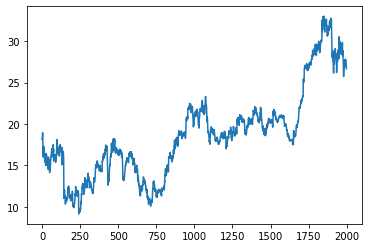

In [6]:
plt.plot(data_np[5000:7000,1])

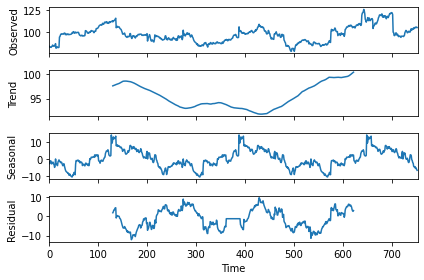

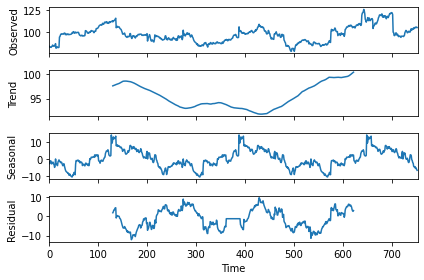

In [7]:
decomp=seasonal_decompose(data_np[9283:10036,1],freq=261,model='additive')
decomp.plot()

In [8]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [9]:
time=data_np[:9700,0]
series=data_np[:9700,1]
split_time = 7000
train_time=time[:split_time]
valid_time=time[split_time:]
train_series=series[:split_time]
valid_series=series[split_time:]

In [10]:
window_size=100
train_data=window_dataset(train_series,window_size)
valid_data=window_dataset(valid_series,window_size)

In [28]:
keras.backend.clear_session()

In [29]:
model=tf.keras.Sequential([tf.keras.layers.Dense(1,input_shape=[window_size])])

In [30]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.00001,momentum=0.9),loss=keras.losses.Huber(),metrics=["mae"])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 101       
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.fit(train_data,epochs=100,validation_data=valid_data)

Epoch 1/100
216/216 [==============================] - 2s 9ms/step - loss: 2.2444 - mae: 2.6697 - val_loss: 2.7361 - val_mae: 3.2021
Epoch 2/100
216/216 [==============================] - 2s 9ms/step - loss: 0.5006 - mae: 0.8262 - val_loss: 2.3819 - val_mae: 2.8425
Epoch 3/100
216/216 [==============================] - 2s 9ms/step - loss: 0.4282 - mae: 0.7416 - val_loss: 2.2515 - val_mae: 2.7082
Epoch 4/100
216/216 [==============================] - 2s 9ms/step - loss: 0.3778 - mae: 0.6822 - val_loss: 2.1304 - val_mae: 2.5854
Epoch 5/100
216/216 [==============================] - 2s 9ms/step - loss: 0.3320 - mae: 0.6269 - val_loss: 1.6982 - val_mae: 2.1409
Epoch 6/100
216/216 [==============================] - 2s 9ms/step - loss: 0.3034 - mae: 0.5880 - val_loss: 1.5868 - val_mae: 2.0280
Epoch 7/100
216/216 [==============================] - 2s 9ms/step - loss: 0.2821 - mae: 0.5609 - val_loss: 1.7104 - val_mae: 2.1574
Epoch 8/100
216/216 [==============================] - 2s 9ms/step - 

In [16]:
def model_forecast(model,series,window_size):
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(size=window_size, shift=1,drop_remainder=True)
  dataset=dataset.flat_map(lambda w: w.batch(window_size))
  dataset=dataset.batch(32).prefetch(1)
  lin_forecast=model.predict(dataset)
  return lin_forecast

In [17]:
#lin_forecast=model_forecast(model,series[split_time-window_size:-1],window_size)
lin_forecast=model_forecast(model,data_np[8000-window_size:-1,1],window_size)

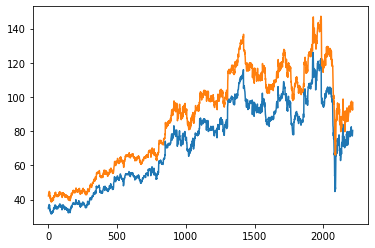

In [18]:
#plt.plot(valid_time,valid_series)
#plt.plot(valid_time,lin_forecast)
plt.plot(data_np[8000:-1,1])
plt.plot(lin_forecast)
plt.show()

In [19]:
lin_forecast

array([[42.172596],
       [42.42984 ],
       [43.363895],
       ...,
       [92.322266],
       [92.68906 ],
       [96.753105]], dtype=float32)

# Reinforcement Learning:

In [20]:
initial_data=data_np[9700-window_size-1:9700,1]

In [33]:
initial_data=data_np[9700-window_size-1:9700,1]
rein_data=initial_data
pred_rein=np.zeros(3100,dtype=float)
for i in range(0,3100):
  rein_forecast=model_forecast(model,rein_data,window_size)
  rein_data=np.append(rein_data[1:],rein_forecast)
  input_rein=window_dataset(rein_data,window_size,batch_size=1,shuffle_buffer=1)
  model.fit(input_rein,epochs=10,validation_data=valid_data)
  pred_rein[i]=rein_forecast[1]
  

Epoch 1/10
2/2 [==============================] - 1s 273ms/step - loss: 5.6430 - mae: 6.1430 - val_loss: 3.2908 - val_mae: 3.7850
Epoch 2/10
2/2 [==============================] - 1s 262ms/step - loss: 2.3043 - mae: 2.8043 - val_loss: 1.7899 - val_mae: 2.2576
Epoch 3/10
2/2 [==============================] - 1s 264ms/step - loss: 5.8073 - mae: 6.3073 - val_loss: 1.7755 - val_mae: 2.2429
Epoch 4/10
2/2 [==============================] - 1s 287ms/step - loss: 2.1712 - mae: 2.6712 - val_loss: 2.9864 - val_mae: 3.4777
Epoch 5/10
2/2 [==============================] - 1s 268ms/step - loss: 5.9151 - mae: 6.4151 - val_loss: 0.9986 - val_mae: 1.4193
Epoch 6/10
2/2 [==============================] - 1s 265ms/step - loss: 2.0478 - mae: 2.3673 - val_loss: 2.9188 - val_mae: 3.4094
Epoch 7/10
2/2 [==============================] - 1s 256ms/step - loss: 4.5406 - mae: 5.0406 - val_loss: 2.6438 - val_mae: 3.1316
Epoch 8/10
2/2 [==============================] - 1s 260ms/step - loss: 4.9396 - mae: 5.43

KeyboardInterrupt: ignored

In [35]:
rein_forecast.size

4097

In [ ]:
plt.clf()
plt.plot(data_np[9700:-1,1])
plt.show()
plt.plot(pred_rein)
plt.show()

In [ ]:
input_rein=window_dataset(initial_data,window_size,batch_size=1,shuffle_buffer=1)

In [ ]:
model.fit(input_rein,epochs=2)

In [ ]:
input_rein.take(1)

In [ ]:
train_data

In [ ]:
for i in range(len(pred_rein)):
  print(pred_rein[i])